In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import seaborn as sns
import pymc as pm
import seaborn as sns
sns.set()





# Coversion Analysis of Cricket Data, Quokkas CC

# Introduction

This python notebook works through a tutorial of how to perform hierachical bayesian analysis on cricket data. One of the teams i've played for in the past is Quokkas CC: http://quokkascc.com//.  Quokkas are a global cricket franchise playing across multiple formats, one core format is the LMS (T20). One of the good aspects of LMS is the richness of the source of data, therefore presents itself as a perfect repository to perform data analysis on.

The data we're going to be accessing is the batsman score per innings in a game, which also contains other information about their innings. The overall mission of the notebook is to find the overall probability of a player converting a score to a 50. However this problem can be generalised to any context when analysing conversions, e.g website conversions.

In [8]:
df = pd.read_csv("scorecard.csv").drop(columns = "Unnamed: 0")

## Charting & EDA

Plotting the histogram of runs scored, you can see the big modal spike at 50, then a small number of innings after this point. This is essentially a semi-censoring issue, we would have expected players at 50 to reach a higher score

Text(0, 0.5, 'Number of Occurances')

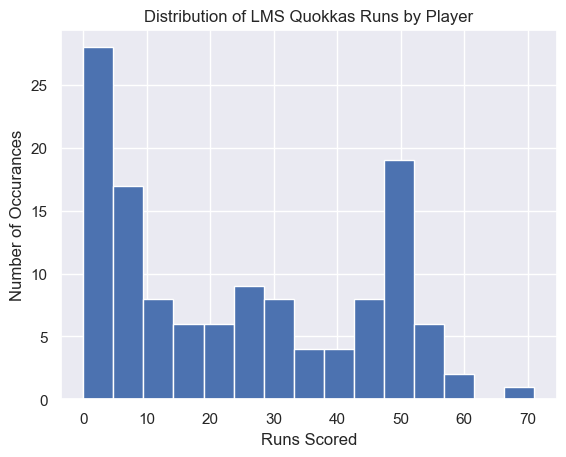

In [9]:
#Plotting a histogram of the runs scored
plt.hist(df["Runs"].values.astype(int),bins=15, cumulative=False);
plt.title("Distribution of LMS Quokkas Runs by Player")
plt.xlabel("Runs Scored")
plt.ylabel("Number of Occurances")


# Truncating the data

In my first analysis, i'm only interested in the first innings score. In later tutorials, i will work in some methods we can account for the censored data issue. Therefore any observations over 50, I will truncate and recode the score as 50.

In [10]:
df['Runs'] = np.where(df['Runs'] > 50, 50, df['Runs'])


Text(0, 0.5, 'Number of Occurances')

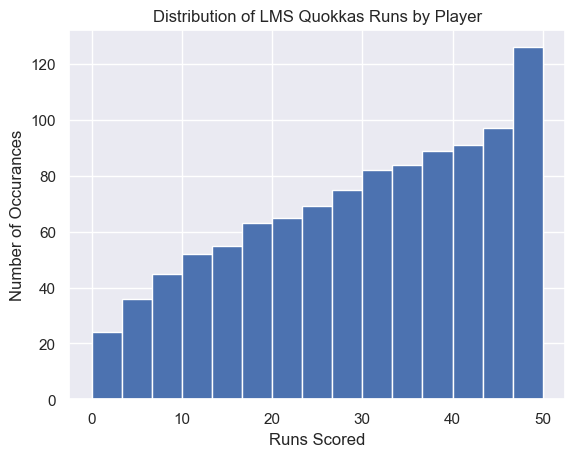

In [11]:
#Plotting a histogram of the runs scored
plt.hist(df["Runs"].values.astype(int),bins=15, cumulative=True);
plt.title("Distribution of LMS Quokkas Runs by Player")
plt.xlabel("Runs Scored")
plt.ylabel("Number of Occurances")

## Heteroscedasicity of the data

It's also interesting to look at the relationship between the number of runs and balls. As we can see the level of heteroscedasdicity of runs increases as the number of balls increases. If this was of interest, there are other statistical techniques we can use to control for this.

I've included a dotted line where the data has now been truncated at 50

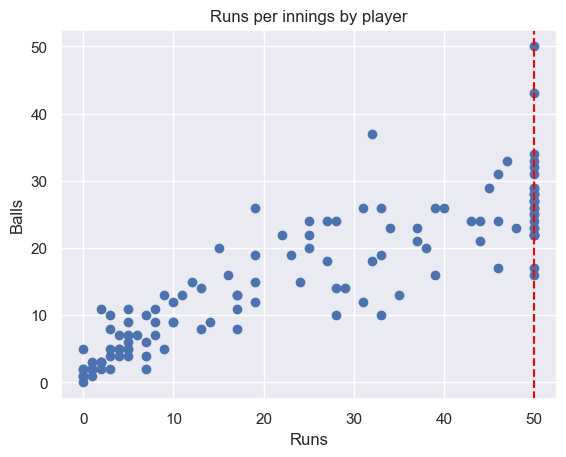

In [12]:
# Convert columns to integers
df['Runs'] = df['Runs'].astype(int)
df['Balls'] = df['Balls'].astype(int)

plt.scatter(df['Runs'], df['Balls'])
plt.axvline(x=50, linestyle='--', color='red')
plt.title("Runs per innings by player")
plt.xlabel('Runs')
plt.ylabel('Balls')
plt.show()

## Methods of dismissal

Exploring the method of dismissal on this chart is of interest too. We can see that generally there is a higher occurance of LBW & bowled early in batters innings. This potentially suggests that players of lower ability score less and are more prone to these types of dismissals. Whereas more established batters are often out caught. 

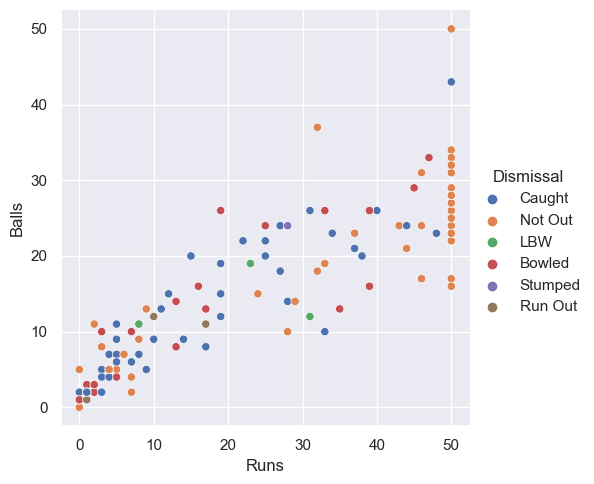

In [13]:
sns.relplot(data=df, x="Runs", y="Balls", hue="Dismissal")

## Data EDA

In addtion to graphical EDA. We can do some calculations on the data to draw out any more insights.

### Most common form of dismissal (including not outs)

In [14]:
# Mode of dismissal for each player
mode_of_dismissal = df.groupby('Batsmen')['Dismissal'].agg(lambda x: x.value_counts().index[0])
print("Mode of Dismissal for each player: \n", mode_of_dismissal)

Mode of Dismissal for each player: 
 Batsmen
Alan          Not Out
Charan         Caught
Dave          Not Out
Guy           Not Out
Herculano      Caught
Jared          Caught
Laurence      Not Out
Loughlin       Bowled
Scott         Not Out
Sohail         Bowled
Tridib        Not Out
Name: Dismissal, dtype: object


### Most common dismissal (excluding not outs)

In [15]:
#Most Common Dismissal ignoring Not Outs
mode_of_dismissal = df.loc[df["Dismissal"] != "Not Out"].groupby("Batsmen")["Dismissal"].agg(lambda x: x.value_counts().index[0])
print("Most Common Dismissal for each player ignoring Not Outs: \n", mode_of_dismissal)

Most Common Dismissal for each player ignoring Not Outs: 
 Batsmen
Alan           Caught
Charan         Caught
Dave           Caught
Guy           Run Out
Herculano      Caught
Jared          Caught
Laurence       Bowled
Loughlin       Bowled
Scott          Bowled
Sohail         Bowled
Tridib         Caught
Name: Dismissal, dtype: object


### Quickest 50 scored (Each innings is 100 balls and 60 minutes long)

In [16]:
# Top 10 quickest 50s
df['Minutes'] = df['Balls'] * 0.6
df['Fifty'] = np.where(df['Runs'] >= 50, True, False)
top_10_quickest_50s = df.loc[df['Fifty'] == True].sort_values(by='Minutes').head(10)
print("Top 10 Quickest 50s: \n", top_10_quickest_50s[['Batsmen', 'Minutes']])

Top 10 Quickest 50s: 
        Batsmen  Minutes
119     Jared       9.6
8    Laurence      10.2
31   Laurence      13.2
28      Scott      13.2
1      Charan      13.2
6         Guy      13.2
89      Scott      13.8
66     Charan      13.8
64     Charan      14.4
4        Dave      15.0


### Slowest strike-rate in an innings (more than 15 balls)

In [17]:
# 10 innings with slowest strike rate (faced more than 10 balls)
df['Strike Rate'] = df['Runs'] / df['Balls'] * 100
slow_strike_rate = df.loc[(df['Balls'] >= 15) & (df['Strike Rate'] < 120)].sort_values(by='Strike Rate').head(10)
print("10 Innings with Slowest Strike Rate (faced more than 10 balls): \n", slow_strike_rate[['Batsmen', 'Strike Rate']])

10 Innings with Slowest Strike Rate (faced more than 10 balls): 
         Batsmen  Strike Rate
124       Alan     73.076923
63   Herculano     75.000000
85        Alan     80.000000
100     Tridib     86.486486
39        Alan    100.000000
76      Charan    100.000000
77        Alan    100.000000
123      Jared    100.000000
122      Scott    104.166667
21        Alan    112.500000


### Average number of runs per dismissal type

In [18]:
# Find the average number of runs per dismissal for each player
average_runs_per_dismissal = df.groupby(['Batsmen', 'Dismissal'])['Runs'].mean().reset_index()
print("Average Runs per Dismissal for each player: \n", average_runs_per_dismissal)

Average Runs per Dismissal for each player: 
        Batsmen Dismissal       Runs
0        Alan     Bowled  26.000000
1        Alan     Caught  12.250000
2        Alan        LBW   2.000000
3        Alan    Not Out  27.600000
4        Alan    Stumped  28.000000
5      Charan     Bowled  10.500000
6      Charan     Caught  34.750000
7      Charan        LBW   0.000000
8      Charan    Not Out  50.000000
9        Dave     Bowled  16.333333
10       Dave     Caught   6.333333
11       Dave    Not Out  33.000000
12       Dave    Run Out  10.000000
13        Guy    Not Out  14.500000
14        Guy    Run Out  17.000000
15  Herculano     Bowled   6.666667
16  Herculano     Caught  17.250000
17  Herculano        LBW  23.000000
18  Herculano    Not Out  50.000000
19      Jared     Bowled   2.000000
20      Jared     Caught  12.200000
21      Jared        LBW  31.000000
22      Jared    Not Out  47.333333
23   Laurence     Bowled  47.000000
24   Laurence    Not Out  50.000000
25   Loughlin     

### Number of times each player has been dismissed for each dismissal type

In [19]:
#Find the number of times each player has been dismissed for each mode of dismissal
dismissal_count = df.groupby(['Batsmen', 'Dismissal']).size().reset_index(name='Count')
print("Count of Dismissals for each player: \n", dismissal_count)


Count of Dismissals for each player: 
        Batsmen Dismissal  Count
0        Alan     Bowled      2
1        Alan     Caught      8
2        Alan        LBW      1
3        Alan    Not Out     10
4        Alan    Stumped      1
5      Charan     Bowled      2
6      Charan     Caught      8
7      Charan        LBW      1
8      Charan    Not Out      7
9        Dave     Bowled      3
10       Dave     Caught      3
11       Dave    Not Out      3
12       Dave    Run Out      1
13        Guy    Not Out      4
14        Guy    Run Out      1
15  Herculano     Bowled      3
16  Herculano     Caught      4
17  Herculano        LBW      1
18  Herculano    Not Out      1
19      Jared     Bowled      1
20      Jared     Caught     10
21      Jared        LBW      1
22      Jared    Not Out      9
23   Laurence     Bowled      1
24   Laurence    Not Out      3
25   Loughlin     Bowled      2
26   Loughlin     Caught      1
27   Loughlin    Run Out      1
28      Scott     Bowled      6
2

### Percentage of innings a player has hit 50

In [20]:
#% Innings player hits 50
player_50s = df.groupby('Batsmen')['Fifty'].sum()
player_innings = df.groupby('Batsmen').size()
percent_innings_50 = (player_50s / player_innings) * 100
print("Percentage of Innings player has hit a 50: \n", percent_innings_50)

Percentage of Innings player has hit a 50: 
 Batsmen
Alan           9.090909
Charan        44.444444
Dave          10.000000
Guy           20.000000
Herculano     11.111111
Jared         33.333333
Laurence      75.000000
Loughlin       0.000000
Scott         20.000000
Sohail         0.000000
Tridib         0.000000
dtype: float64


### Average minutes per innings by each batter

In [21]:
#Average number of minutes per inning
average_minutes_per_inning = df.groupby('Batsmen')['Minutes'].mean()
print("Average number of minutes per inning: \n", average_minutes_per_inning)

Average number of minutes per inning: 
 Batsmen
Alan           9.518182
Charan        12.533333
Dave           8.220000
Guy            5.640000
Herculano      8.000000
Jared          9.571429
Laurence      15.450000
Loughlin       0.900000
Scott         10.950000
Sohail         3.975000
Tridib         9.240000
Name: Minutes, dtype: float64


### Number of innings by batter

In [22]:
df.groupby('Batsmen').size()

Batsmen
Alan          22
Charan        18
Dave          10
Guy            5
Herculano      9
Jared         21
Laurence       4
Loughlin       4
Scott         20
Sohail         8
Tridib         5
dtype: int64

### Average runs by batting order and batter

In [23]:
#Average runs at each batting order
average_runs_per_inning = df.groupby(['Batsmen', 'batting number'])['Runs'].mean().reset_index()
print("Average Runs per Inning for each player at each batting position: \n", average_runs_per_inning)


Average Runs per Inning for each player at each batting position: 
        Batsmen  batting number       Runs
0        Alan                1  17.000000
1        Alan                2  27.000000
2        Alan                3  35.250000
3        Alan                4  28.000000
4        Alan                5  18.400000
5        Alan                6  32.000000
6        Alan                7  11.333333
7        Alan                8   7.000000
8      Charan                1  36.250000
9      Charan                2  46.571429
10     Charan                4  16.500000
11     Charan                5   0.000000
12       Dave                2  50.000000
13       Dave                3  45.000000
14       Dave                4   2.000000
15       Dave                5  10.000000
16       Dave                6  18.000000
17       Dave                7   3.000000
18       Dave                8  11.000000
19        Guy                4  50.000000
20        Guy                6   5.666667
21      

## Interesting aspects to learn from the data

We've run through a lot of descriptive statistics, but within it there are some fascinating features present in the data:

1. Charan is not out in 7 innings, in all of these innings he has gone on to reach 50. This 'game finisher' club is a small one with Herc and Laurence in it. Jared narrowly misses out in this club

2. Jareds most common form of dismissal is caught (10 times), he has only been bowled once and LBW once. His average in this mode of dismissal is 12.2, implying he gets out early through attempting big hits.

3. Alan comes up 4 times out of the 10 slowest innings. However has a consistently good average across all batting positions in the order. Additionally most often achieves a not out in the innings

4. Laurance has a remarkable conversion rate to 50s (75%). However this only in a sample size of 4

5. Not all batters have achieved to score a 50

The last 2 points are interesting aspects i'm going to dig deeper on

## Probability of scoring a 50

The interesting compontent I want to pick up on is an analysis into the player conversion rates to 50. For some players we have a high conversion rate to 50, but a small sample size of innings. For others they have never hit a 50. We may pose the question, what is the true probability of hitting a 50 for each player? We can think this question is analogous to the coin tossing problem. If we toss a coint 4 times and acheive 4 heads. We are unlikely to suggest the coin has a probability of achieving a head 100% of the time.

### Bayesian Model

One way to answer the question is to use a hierachical model. A hierachcial model essentially allows the model to share information across the players, through a shared distbrituion, this is referred to as the global parameter. Players are also able to deviate from this global parameter, with player specific parameters. 

For the probability of hitting a 50, we are going to assume there is are latent distributions which impact the players probability of hitting a 50. These are specified by the alpha and beta parameter, these corresponding parameters have their own global parameter. For players that have few innings, they are more likely to be informed by the global parameters.

The model then takes these variables and transforms them using an inverse logit function. This inverse logit function scales the data between 0 and 1. This can therefore be interpreted as the probability of a player hitting a 50.

A bernoulli distribution is then used. A bernoulli distribution. This is essentially because we can think of the problem being one trial. The player has one innings and either achieves a 50 or doesn't



In [24]:
# Create a list of player names
players = df["Batsmen"].unique()

# Create a mapping from player names to player codes
player_mapping = {player: i for i, player in enumerate(players)}

# Convert player names to player codes
df["Batsmen_code"] = df["Batsmen"].map(player_mapping)

# Create the hierarchical model
with pm.Model() as model:
    # Global alpha and beta parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)
    
    # Player-specific alpha and beta parameters
    player_alphas = pm.Normal("player_alphas", mu=alpha, sigma=1, shape=len(players))
    player_betas = pm.Normal("player_betas", mu=beta, sigma=1, shape=len(players))

    
    # Calculate player-specific p values
    p = pm.Deterministic("p", pm.math.invlogit(player_alphas[df["Batsmen_code"].values] - player_betas[df["Batsmen_code"].values]))
    
    # Likelihood
    fifty = pm.Bernoulli("fifty", p=p, observed=df["Fifty"].values)
    
    # Sampling
    idata = pm.sample(draws=2000, chains=4)





Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, player_alphas, player_betas]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 83 seconds.


In [25]:
#Specify my own inverse_logit transformation

def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))

In [26]:
pm.summary(idata, var_names=["alpha","beta", "player_alphas","player_betas"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.692,6.568,-12.728,12.049,0.369,0.284,318.0,355.0,1.02
beta,1.053,6.561,-11.026,13.746,0.368,0.262,320.0,346.0,1.02
player_alphas[0],-0.981,6.598,-13.191,11.864,0.370,0.287,321.0,344.0,1.02
player_alphas[1],-0.021,6.598,-12.121,12.906,0.369,0.272,321.0,392.0,1.02
player_alphas[2],-0.240,6.594,-12.651,12.224,0.368,0.277,323.0,387.0,1.02
player_alphas[3],-0.562,6.597,-13.064,11.919,0.370,0.284,320.0,328.0,1.02
player_alphas[4],-0.923,6.607,-13.305,11.610,0.367,0.284,325.0,392.0,1.02
player_alphas[5],-0.656,6.611,-12.912,12.202,0.369,0.278,323.0,383.0,1.02
player_alphas[6],-1.282,6.623,-13.683,11.559,0.368,0.289,325.0,406.0,1.02
player_alphas[7],0.216,6.601,-11.764,13.179,0.367,0.268,324.0,379.0,1.02


Inspecting the trace, it looks like there has been inefficient sampling of the posteriors. This can be caused by varialble correlations. Therefore we may want to look at the pair plots of our variables

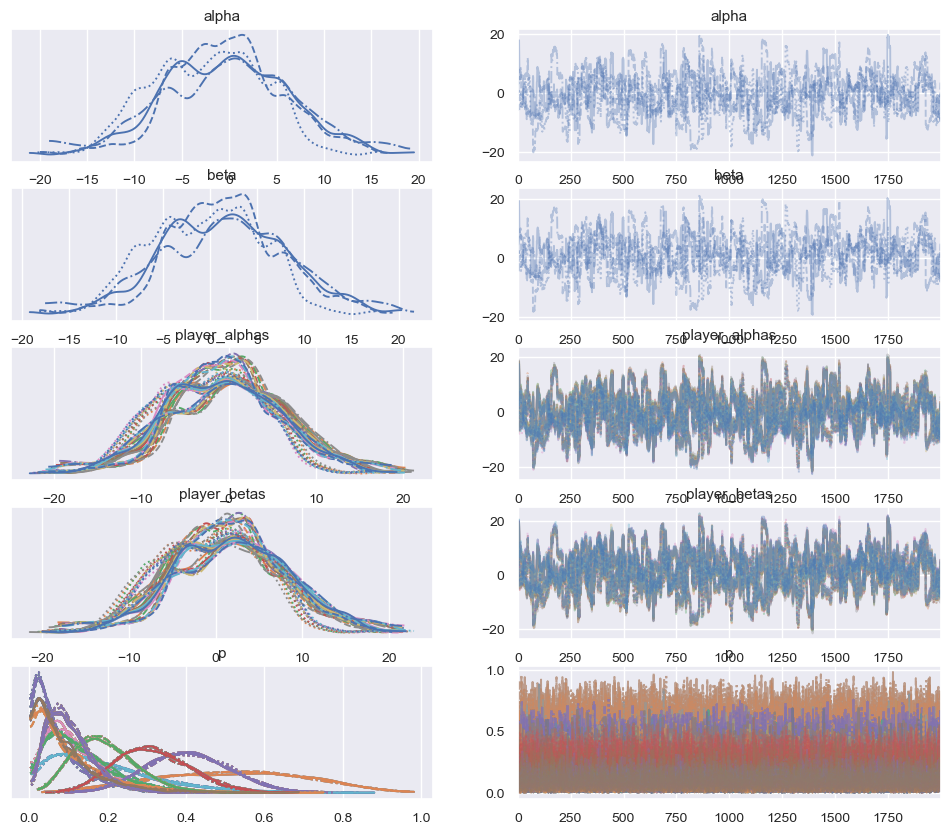

In [27]:
#Inspecting the trace
pm.plot_trace(idata, combined=False);

### Pair Plot

There are near perfect correlations between alpha and beta. Given how the model was specified, this makes sense. Realistically they are both controlling the same thing, therefore we can just remove either the alphas or the betas from the model

<AxesSubplot: xlabel='alpha', ylabel='beta'>

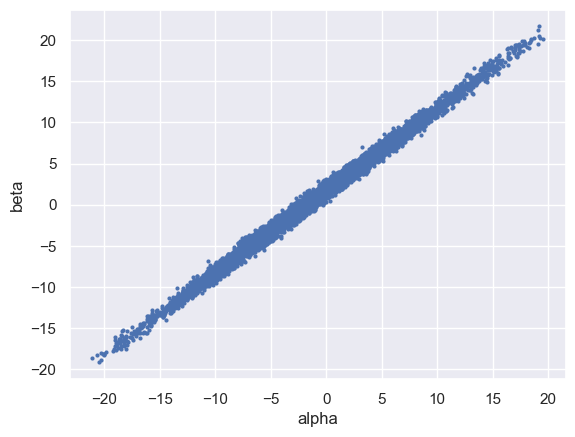

In [28]:
#Plotting correlations between alpha and beta
az.plot_pair(
    idata,
    var_names=["alpha", "beta"]
)

## Re-parametizing the model

For the new model, I have now taken out the beta. I've also respecified the players alpha as a StudentT distribution. That's because I believe there is likely more dispersion in the data, with extremes of players who can consistently hit 50s and ones who cant. The StudentT achieves this as it places more probability in the tails of the distribution.

In [29]:
# Create a list of player names
players = df["Batsmen"].unique()

# Create a mapping from player names to player codes
player_mapping = {player: i for i, player in enumerate(players)}

# Convert player names to player codes
df["Batsmen_code"] = df["Batsmen"].map(player_mapping)

# Create the hierarchical model
with pm.Model() as model:
    # Global alpha and beta parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)

    
    # Player-specific alpha and beta parameters
    player_alphas = pm.StudentT("player_alphas", mu=alpha, nu=1, shape=len(players))

    
    # Calculate player-specific p values
    p = pm.Deterministic("p", pm.math.invlogit(player_alphas[df["Batsmen_code"].values]))
    
    # Likelihood
    fifty = pm.Bernoulli("fifty", p=p, observed=df["Fifty"].values)
    
    # Sampling
    idata = pm.sample(draws=2000, chains=4)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, player_alphas]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 107 seconds.


With the changes to the model, sampling has improved and the r_hats are now all 1

In [30]:
pm.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-1.660,0.545,-2.652,-0.620,0.008,0.006,4954.0,4755.0,1.00
player_alphas[0],-2.231,0.643,-3.439,-1.032,0.008,0.006,7018.0,3938.0,1.00
player_alphas[1],-0.426,0.494,-1.304,0.546,0.006,0.005,6595.0,5114.0,1.00
player_alphas[2],-0.867,0.460,-1.734,-0.005,0.005,0.004,8016.0,5239.0,1.00
player_alphas[3],-1.514,0.538,-2.475,-0.453,0.007,0.005,6891.0,4717.0,1.00
...,...,...,...,...,...,...,...,...,...
p[121],0.089,0.100,0.000,0.273,0.005,0.004,40.0,15.0,1.07
p[122],0.193,0.079,0.054,0.338,0.001,0.001,6891.0,4717.0,1.00
p[123],0.304,0.093,0.142,0.485,0.001,0.001,8016.0,5239.0,1.00
p[124],0.111,0.058,0.014,0.217,0.001,0.000,7018.0,3938.0,1.00


## Summary of results

Now we have run our model, we can extract the posterior values for the players and calculate the true probability of hitting a 50. You can see for some players there is a large amount of uncertainty. This is due to them not having many innings. The certainty behind their conversion rate will imrpove with the number of innings they play. Additonally, we now have probabilities for players who have never previously hit a 50 too, this is because the model has shared information across players.

In [31]:
#Calculating the players probability posteriors
posterior_alpha = idata.posterior.mean(dim="chain")["player_alphas"].values
p50_full_sample = pd.DataFrame(inv_logit((posterior_alpha)))*100

# Get the keys of the mapping dictionary
col_names = list(player_mapping.keys())

# Rename the columns using the keys of the mapping dictionary
print("Probability of hitting a 50")
p50_full_sample.columns = col_names
p50_full_sample.describe().applymap("{:.2f}%".format).drop(["count","std"])


Probability of hitting a 50


,Alan,Charan,Jared,Scott,Dave,Guy,Sohail,Laurence,Herculano,Loughlin,Tridib
mean,10.05%,39.65%,29.82%,18.37%,11.48%,17.03%,2.64%,60.46%,12.22%,3.48%,4.23%
min,2.19%,17.14%,14.84%,7.25%,1.74%,4.42%,0.00%,20.25%,1.84%,0.00%,0.00%
25%,8.07%,35.69%,26.47%,15.55%,8.64%,12.49%,0.03%,50.63%,8.97%,0.00%,0.84%
50%,9.90%,39.55%,29.64%,18.27%,11.04%,16.23%,1.46%,60.46%,11.67%,0.95%,3.03%
75%,11.82%,43.51%,32.73%,20.81%,13.85%,20.84%,4.35%,70.63%,14.92%,5.68%,6.43%
max,22.94%,59.55%,49.89%,33.75%,32.70%,42.49%,21.48%,95.10%,32.92%,29.83%,24.62%
